In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

from skimage.transform import radon, iradon
import pandas as pd

### 1. Load the phantom, get its dimensions, and display it.

In [4]:
x = loadmat('derenzo.mat')

# select variable 'im' and convert it from dictionary to numpy array
image = np.array(x['derenzo'])

print('max:', image.max())

# normalization: the maximum number of photon counts is 255
# but, to keep the maximum value of both the reconstructed image 
# and the original one to 1, both are being normalized in 
# respect to its maximum
image = image/image.max()

# print image size
[rows, cols] = image.shape
print('shape:', rows, cols)

max: 228
shape: 256 256


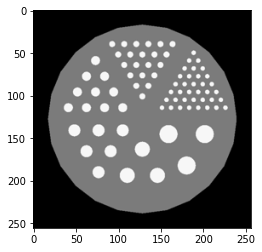

In [5]:
plt.imshow(image, cmap="gray")

### 2. Simulate the sinogram and reconstructed SPECT image of the phantom by filtered back-projection, first without and then with noise (using the random.poisson function of the numpy library; note that values need to be converted to uint8 type prior to applying this function).

* Without noise

Difference between images: 1183.9347129151763


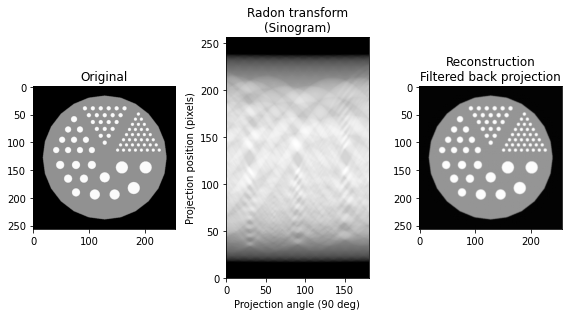

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4.5))

# Plotting the original image
ax1.set_title("Original")
ax1.imshow(image*255/np.max(image), cmap=plt.cm.Greys_r)

# Creating and plotting the sinogram
theta = np.linspace(0, 180, 360, endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (90 deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

# Reconstructing the image from the sinogram and plotting the result
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
ax3.set_title("Reconstruction\nFiltered back projection")
ax3.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)

plt.tight_layout()

# Normalization
reconstruction_fbp = (reconstruction_fbp - reconstruction_fbp.min())/(reconstruction_fbp.max() - reconstruction_fbp.min())
print("Difference between images:", sum(sum(abs(image - reconstruction_fbp))))

* With noise

Difference between images: 13198.435113250778


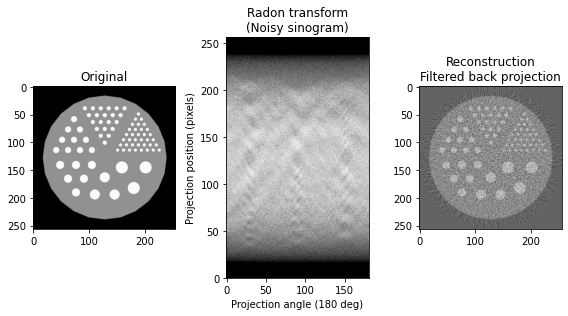

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

sinogram = radon(image, theta=theta)
noisy_sinogram = np.random.poisson(sinogram).astype(np.uint8)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / noisy_sinogram.shape[0]
ax2.set_title("Radon transform\n(Noisy sinogram)")
ax2.set_xlabel("Projection angle (180 deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(noisy_sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, noisy_sinogram.shape[0] + dy),
           aspect='auto')


reconstruction_fbp_noisy = iradon(noisy_sinogram, theta=theta, filter_name='ramp')
ax3.set_title("Reconstruction\nFiltered back projection")
ax3.imshow(reconstruction_fbp_noisy, cmap=plt.cm.Greys_r)

fig.tight_layout()

reconstruction_fbp_noisy = (reconstruction_fbp_noisy - reconstruction_fbp_noisy.min())/(reconstruction_fbp_noisy.max() - reconstruction_fbp_noisy.min())
print("Difference between images:", sum(sum(abs(image - reconstruction_fbp_noisy))))

### 3. Define appropriate ROIs for one of the big, the medium, and the small hotspots (using roipoly in Matlab /Python).

In [8]:
from roipoly import RoiPoly
import matplotlib
# RoiPoly requires a different matplotlib backend
%matplotlib tk
matplotlib.use('TkAgg')
print("Using.... ", matplotlib.pyplot.get_backend())

plt.figure('Drawing an ROI')
plt.imshow(reconstruction_fbp_noisy, cmap='gray')
plt.title('Select big mask')
big_mask = RoiPoly(color='r')  # draw new ROI in red color
plt.title('Select medium mask')
plt.imshow(reconstruction_fbp_noisy, cmap='gray')
medium_mask = RoiPoly(color='r')  # draw new ROI in red color
plt.title('Select small mask')
plt.imshow(reconstruction_fbp_noisy, cmap='gray')
small_mask = RoiPoly(color='r')  # draw new ROI in red color

Using....  TkAgg


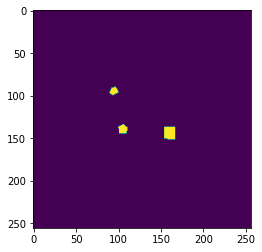

In [9]:
%matplotlib inline
plt.figure()
total = big_mask.get_mask(reconstruction_fbp_noisy) + small_mask.get_mask(reconstruction_fbp_noisy) + medium_mask.get_mask(reconstruction_fbp_noisy)
plt.imshow(total)

m = reconstruction_fbp_noisy[total].mean()
s = reconstruction_fbp_noisy[total].std()

### 4. Illustrate and quantify the partial volume effects (PVE’s) in the reconstructed image, by performing the following analysis and comparing the results with those obtained from the phantom (ground truth):

- Checking the size of the reconstructed image

In [10]:
print(reconstruction_fbp_noisy.shape)
print(reconstruction_fbp_noisy.shape == image.shape == reconstruction_fbp.shape)

(256, 256)
True


#### a. Plot the intensity profile of a specific line in the object/image, going through various hot spots;

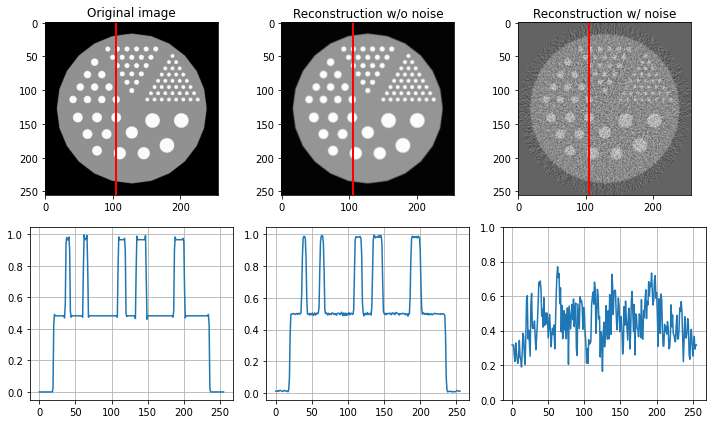

In [11]:
# Position of the horizontal line
x = 105
h, w = image.shape

plt.figure(figsize=(10,6))
plt.subplot(2, 3, 1)
plt.imshow(image, cmap=plt.cm.Greys_r)
plt.title('Original image')
plt.plot((x, x), (0, h-1), 'r-', lw=2)
plt.subplot(2, 3, 2)
plt.title('Reconstruction w/o noise')
plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
plt.plot((x, x), (0, h-1), 'r-', lw=2)
plt.subplot(2, 3, 3)
plt.title('Reconstruction w/ noise')
plt.imshow(reconstruction_fbp_noisy, cmap=plt.cm.Greys_r)
plt.plot((x, x), (0, h-1), 'r-', lw=2)

plt.subplot(2, 3, 4)
plt.plot(image[:, x])
plt.grid()
plt.subplot(2, 3, 5)
plt.plot(reconstruction_fbp[:, x])
plt.grid()
plt.subplot(2, 3, 6)
plt.plot(reconstruction_fbp_noisy[:, x])
plt.ylim([0, 1])
plt.grid()
plt.tight_layout()

#### b. Compute the average image intensities and SNR in each ROI.

- Big hotspot

In [28]:
mask = big_mask.get_mask(reconstruction_fbp_noisy2)

m_big = reconstruction_fbp_noisy[mask].mean()
s_noise_big = reconstruction_fbp_noisy[mask].std()
snr_big =  m_big / s_noise_big

mask = medium_mask.get_mask(reconstruction_fbp_noisy)

m_medium = reconstruction_fbp_noisy[mask].mean()
s_noise_medium = reconstruction_fbp_noisy[mask].std()
snr_medium =  m_medium / s_noise_medium

mask = small_mask.get_mask(reconstruction_fbp_noisy)

m_small = reconstruction_fbp_noisy[mask].mean()
s_noise_small = reconstruction_fbp_noisy[mask].std()
snr_small =  m_small / s_noise_small 

original_metrics = pd.DataFrame({
    'Big hotspot':[m_big, snr_big],
    'Medium hotspot':[m_medium, snr_medium],
    'Small hotspot':[m_small, snr_small],
    }, index=['Average intensity', 'SNR'])

original_metrics.head()

,Big hotspot,Medium hotspot,Small hotspot
Average intensity,0.603219,0.603523,0.578568
SNR,5.188254,6.417890,5.298163


- Medium hotspot

In [13]:
mask = medium_mask.get_mask(reconstruction_fbp_noisy)

m = reconstruction_fbp_noisy[mask].mean()
s_noise = reconstruction_fbp_noisy[mask].std()
snr =  m / s_noise 
print("SNR = %.2f" % (snr))
print("Average Intensity: %0.2f" % m)

SNR = 6.42
Average Intensity: 0.60


- Small hotspot

In [14]:
mask = small_mask.get_mask(reconstruction_fbp_noisy)

m = reconstruction_fbp_noisy[mask].mean()
s_noise = reconstruction_fbp_noisy[mask].std()
snr =  m / s_noise 
print("SNR = %.2f" % (snr))
print("Average Intensity: %0.2f" % m)

SNR = 5.30
Average Intensity: 0.58


## 5. Repeat the analysis in 4., by now changing the spatial resolution and/or the SNR of the image (through manipulation of the appropriate image acquisition parameters).

- Changing the SNR: 
    - Dividing by half the injected dose

Difference between images: 15242.474224294032


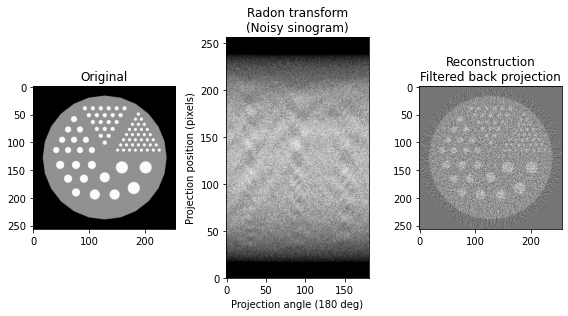

In [15]:
import warnings
warnings.filterwarnings('ignore')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

sinogram = radon(image, theta=theta)
noisy_sinogram2 =np.random.poisson(sinogram * 63.0 / np.max(sinogram)).astype(np.uint8)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / noisy_sinogram2.shape[0]
ax2.set_title("Radon transform\n(Noisy sinogram)")
ax2.set_xlabel("Projection angle (180 deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(noisy_sinogram2, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, noisy_sinogram2.shape[0] + dy),
           aspect='auto')


reconstruction_fbp_noisy2 = iradon(noisy_sinogram2, theta=theta, filter_name='ramp')
reconstruction_fbp_noisy2 = reconstruction_fbp_noisy2/np.max(reconstruction_fbp_noisy2)
ax3.set_title("Reconstruction\nFiltered back projection")
ax3.imshow(reconstruction_fbp_noisy2, cmap=plt.cm.Greys_r)

fig.tight_layout()

reconstruction_fbp_noisy2 = (reconstruction_fbp_noisy2 - reconstruction_fbp_noisy2.min())/(reconstruction_fbp_noisy2.max() - reconstruction_fbp_noisy2.min())
print("Difference between images:", sum(sum(abs(image - reconstruction_fbp_noisy2))))

Difference between images: 6837.7189201896745


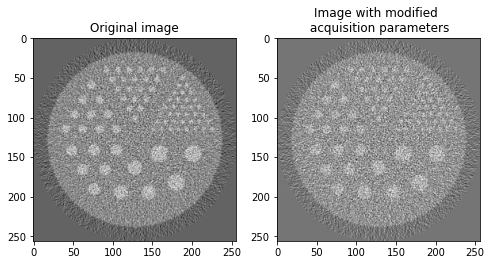

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original image")
ax1.imshow(reconstruction_fbp_noisy, cmap=plt.cm.Greys_r, )#vmin=-5, vmax=10)

ax2.set_title("Image with modified \n acquisition parameters")
ax2.imshow(reconstruction_fbp_noisy2, cmap=plt.cm.Greys_r, )#vmin=-5, vmax=10)

print("Difference between images:", sum(sum(abs(reconstruction_fbp_noisy2 - reconstruction_fbp_noisy))))

- Checking the size of the reconstructed image

In [17]:
print(reconstruction_fbp_noisy2.shape)
print(reconstruction_fbp_noisy2.shape == image.shape)

(256, 256)
True


#### a. Plot the intensity profile of a specific line in the object/image, going through various hot spots;

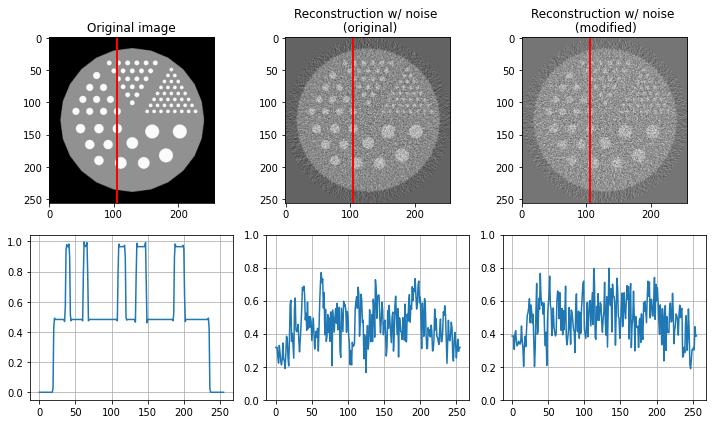

In [36]:
# Position of the horizontal line
x = 105
h, w = image.shape

plt.figure(figsize=(10,6))
plt.subplot(2, 3, 1)
plt.imshow(image, cmap=plt.cm.Greys_r)
plt.title('Original image')
plt.plot((x, x), (0, h-1), 'r-', lw=2)
plt.subplot(2, 3, 2)
plt.title('Reconstruction w/ noise \n (original)')
plt.imshow(reconstruction_fbp_noisy, cmap=plt.cm.Greys_r)
plt.plot((x, x), (0, h-1), 'r-', lw=2)
plt.subplot(2, 3, 3)
plt.title('Reconstruction w/ noise \n (modified)')
plt.imshow(reconstruction_fbp_noisy2, cmap=plt.cm.Greys_r)
plt.plot((x, x), (0, h-1), 'r-', lw=2)

plt.subplot(2, 3, 4)
plt.plot(image[:, x])
plt.grid()
plt.subplot(2, 3, 5)
plt.plot(reconstruction_fbp_noisy[:, x])
plt.grid()
plt.ylim([0, 1])
plt.subplot(2, 3, 6)
plt.plot(reconstruction_fbp_noisy2[:, x])
plt.ylim([0, 1])
plt.grid()
plt.tight_layout()

#### b. Compute the average image intensities and SNR in each ROI.

In [29]:
mask = big_mask.get_mask(reconstruction_fbp_noisy2)

m_big = reconstruction_fbp_noisy2[mask].mean()
s_noise_big = reconstruction_fbp_noisy2[mask].std()
snr_big =  m_big / s_noise_big

mask = medium_mask.get_mask(reconstruction_fbp_noisy2)

m_medium = reconstruction_fbp_noisy2[mask].mean()
s_noise_medium = reconstruction_fbp_noisy2[mask].std()
snr_medium =  m_medium / s_noise_medium

mask = small_mask.get_mask(reconstruction_fbp_noisy2)

m_small = reconstruction_fbp_noisy2[mask].mean()
s_noise_small = reconstruction_fbp_noisy2[mask].std()
snr_small =  m_small / s_noise_small 

manipulated_metrics = pd.DataFrame({
    'Big hotspot':[m_big, snr_big],
    'Medium hotspot':[m_medium, snr_medium],
    'Small hotspot':[m_small, snr_small],
    }, index=['Average intensity', 'SNR'])

In [33]:
original_metrics

,Big hotspot,Medium hotspot,Small hotspot
Average intensity,0.603219,0.603523,0.578568
SNR,5.188254,6.417890,5.298163


In [35]:
manipulated_metrics

,Big hotspot,Medium hotspot,Small hotspot
Average intensity,0.589881,0.580480,0.566634
SNR,5.202415,4.993665,5.091768
